In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder

# from ipynb.fs.full.Functions import factorial

RANDOM_SEED = 1235846
import warnings
warnings.filterwarnings("ignore")

In [2]:
def model_predictions(model, x_train, y_train, x_test=None, y_test=None):

    '''Enter model name and test/train sets to generate predictions, precision, recall, accuracy, and F1 score'''
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    if x_test is not None:
        y_hat_test = model.predict(x_test)
    print('Training Precision: ', precision_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Precision: ', precision_score(y_test, y_hat_test))
    print('-----')

    print('Training Recall: ', recall_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Recall: ', recall_score(y_test, y_hat_test))
    print('-----')

    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
    print('-----')

    print('Training F1-Score: ', f1_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing F1-Score: ', f1_score(y_test, y_hat_test))
    if x_test is not None:
        return precision_score(y_test, y_hat_test), accuracy_score(y_test, y_hat_test), y_hat_test
    return precision_score(y_train, y_hat_train), accuracy_score(y_train, y_hat_train), y_hat_train

In [3]:
features_df = pd.read_csv('./data/flu_training_set_features.csv', index_col='respondent_id')
labels_df = labels_df = pd.read_csv("./data/flu_training_set_labels.csv", index_col="respondent_id")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size=0.25,
    random_state=RANDOM_SEED
)

In [5]:
drop_features = ['hhs_geo_region', 'employment_industry','employment_occupation']
X_train.drop(drop_features, axis=1, inplace=True)
X_test.drop(drop_features, axis=1, inplace=True)
numeric_features = [col for col in X_train.columns if X_train[col].dtype != 'O']
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'O']

In [6]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median", add_indicator=True))]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [7]:
models = {'Logistic':
              {'regressor': LogisticRegression(random_state=RANDOM_SEED),
               'preprocessor': preprocessor},
          'Naive_Bayes':
              {'regressor': GaussianNB(),
               'preprocessor': preprocessor},
          'Decision_Trees':
              {'regressor': DecisionTreeClassifier(random_state=RANDOM_SEED),
               'preprocessor': preprocessor},
          'KNN':
              {'regressor': KNeighborsClassifier(),
               'preprocessor': preprocessor},
          'Random_Forest':
              {'regressor': RandomForestClassifier(random_state=RANDOM_SEED),
               'preprocessor': preprocessor},
          'G_Boost':
              {'regressor': GradientBoostingClassifier(random_state=RANDOM_SEED),
               'preprocessor': preprocessor},
          'Hist_Boost':
              {'regressor': HistGradientBoostingClassifier(random_state=RANDOM_SEED),
               'preprocessor': preprocessor}
              }

In [8]:
precision_dict = {}
accuracy_dict = {}
auc_dict = {}
for name, model in models.items():  
    print(name)
    X_train_processed = model['preprocessor'].fit_transform(X_train)
    X_test_processed = model['preprocessor'].transform(X_test)
    model['fit_regressor'] = model['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
    print(model)
    precision_dict[name], accuracy_dict[name], y_hat_test = model_predictions(model['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)
    auc_dict[name] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
    print(f'Area under the curve for {name} model: {auc_dict[name]}.')

Logistic
{'regressor': LogisticRegression(random_state=1235846), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                                  'opinion_h1n1_risk',
              

## Baseline

In [9]:
# Using only 1 column as predicator
base_X_train = X_train.copy()
base_X_train.drop(base_X_train.columns.difference(['opinion_seas_risk']), 1, inplace=True)
base_X_test = X_test.copy()
base_X_test.drop(base_X_test.columns.difference(['opinion_seas_risk']), 1, inplace=True)
base_X_train.fillna(value=2, inplace=True)
base_X_test.fillna(value=2, inplace=True)

Baseline
{'Baseline': {'regressor': LogisticRegression(random_state=1235846), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                                  'opinion_h1n1_risk',
 

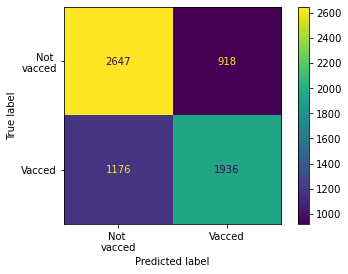

In [10]:
model_baseline = {'Baseline':
              {'regressor': LogisticRegression(random_state=RANDOM_SEED),
               'preprocessor': preprocessor}}

model = 'Baseline'
print(model)
model_baseline[model]['fit_regressor'] = model_baseline[model]['regressor'].fit(base_X_train, y_train.seasonal_vaccine)
print(model_baseline)
precision_dict[model], accuracy_dict[model], y_hat_test = model_predictions(model_baseline[model]['fit_regressor'], base_X_train, y_train.seasonal_vaccine, base_X_test, y_test.seasonal_vaccine)

auc_dict[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc_baseline = auc_dict[model]
print(f'Area under the curve for {model} model: {auc_baseline}.')

cm_baseline = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_baseline, display_labels=['Not \nvacced', 'Vacced']).plot();

In [11]:
auc_dict

{'Logistic': 0.7740200355498509,
 'Naive_Bayes': 0.6929602011126454,
 'Decision_Trees': 0.6710216435857037,
 'KNN': 0.7162361144661933,
 'Random_Forest': 0.7766262434335531,
 'G_Boost': 0.7834124882371817,
 'Hist_Boost': 0.7817170199418078,
 'Baseline': 0.6823022314201553}

In [12]:
auc_lst = [auc for auc in auc_dict.values()]
auc_lst

[0.7740200355498509,
 0.6929602011126454,
 0.6710216435857037,
 0.7162361144661933,
 0.7766262434335531,
 0.7834124882371817,
 0.7817170199418078,
 0.6823022314201553]

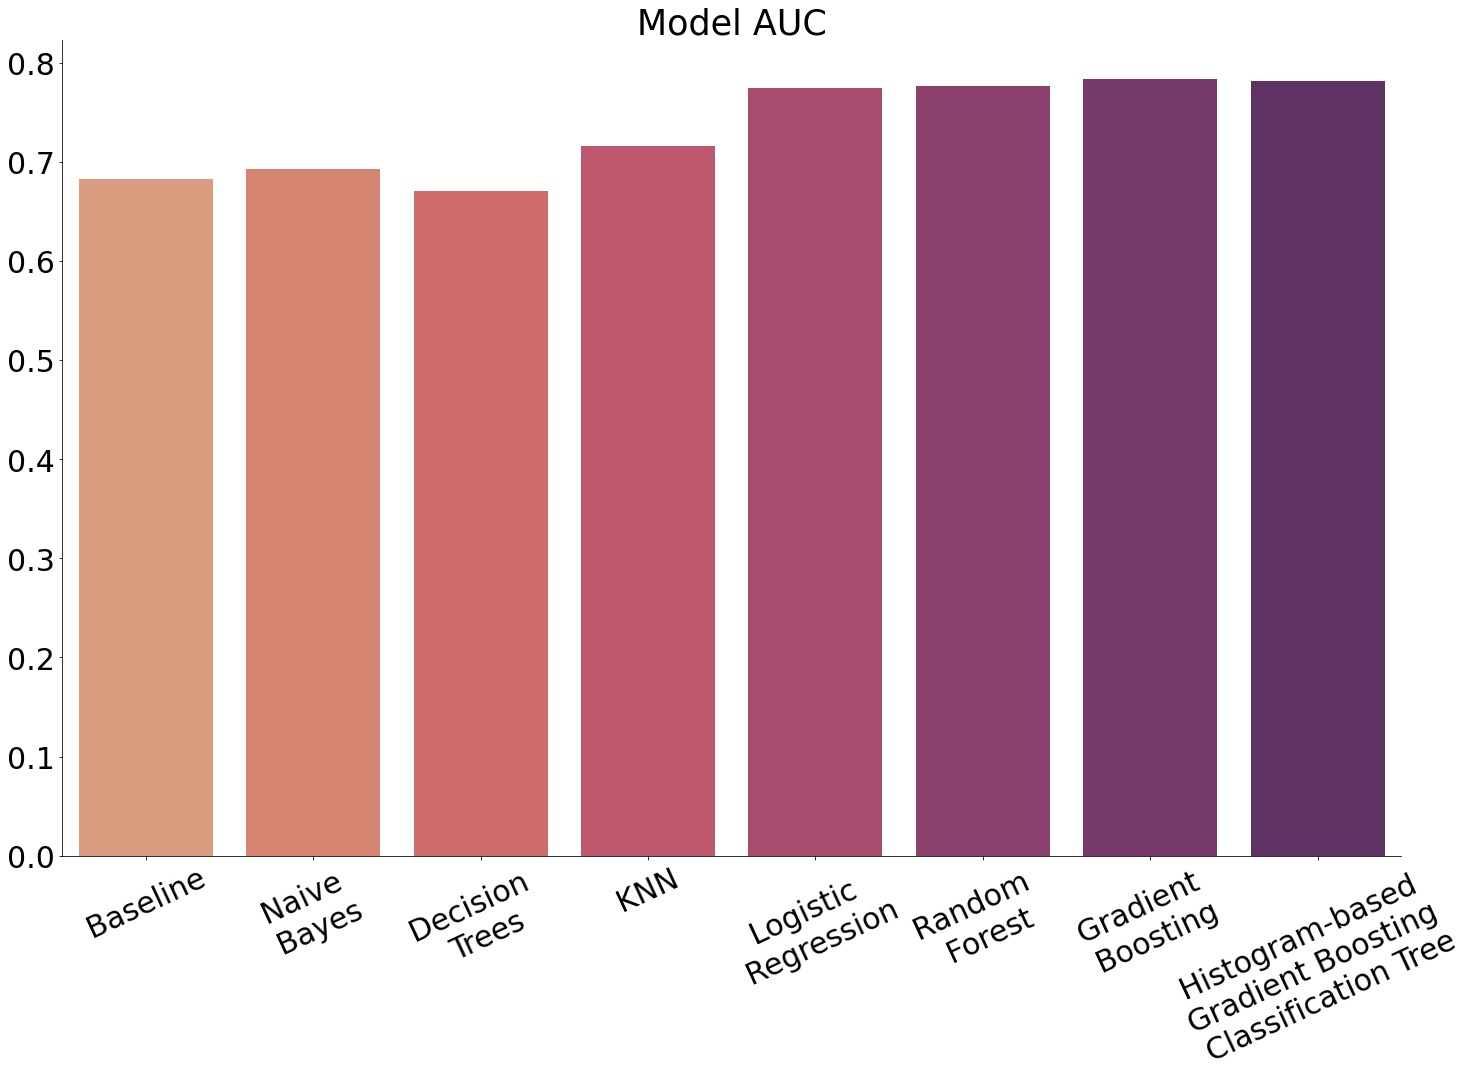

In [97]:
AUC = [auc_lst[7], auc_lst[1], auc_lst[2], auc_lst[3], auc_lst[0], auc_lst[4], auc_lst[5], auc_lst[6]]
names = ['Baseline', 'Naive \nBayes', 'Decision \nTrees', 'KNN', 'Logistic \nRegression', 'Random \nForest', 'Gradient \nBoosting', 'Histogram-based \nGradient Boosting \nClassification Tree']

fig, ax = plt.subplots(figsize=(24, 15))
x_label = names
ax = sns.barplot(x_label, AUC, palette="flare")
plt.xticks(rotation=25, size=30)
plt.yticks(size=30)
sns.despine()
ax.set_title('Model AUC', fontsize=35)
# plt.savefig('Skyler_graph_2', bbox_inches='tight');

In [14]:
precision_dict

{'Logistic': 0.7746526601152152,
 'Naive_Bayes': 0.6257470119521913,
 'Decision_Trees': 0.6526592252133946,
 'KNN': 0.7037037037037037,
 'Random_Forest': 0.7786467188031282,
 'G_Boost': 0.7829744279946165,
 'Hist_Boost': 0.7753551370994384,
 'Baseline': 0.6783461807988788}

In [15]:
accuracy_dict

{'Logistic': 0.7766961210124307,
 'Naive_Bayes': 0.6851879586640707,
 'Decision_Trees': 0.673206529878688,
 'KNN': 0.7184364235435076,
 'Random_Forest': 0.7793919424891418,
 'G_Boost': 0.785831960461285,
 'Hist_Boost': 0.7835854425640257,
 'Baseline': 0.6863861015426089}

## Tuning Naive Bayes

In [16]:
# # Grid_search for Naive Bayes
# pipeline_nb = Pipeline([( "preprocessor" , preprocessor),
#                        ("nb",GaussianNB())])

# parameters_nb = {'nb__var_smoothing': np.logspace(0,-9, num=10)}

# gs_nb=GridSearchCV(pipeline_nb,parameters_nb)

# gs_nb.fit(X_train,y_train.seasonal_vaccine)

# gs_nb.best_params_

In [17]:
# nb_tuned = GaussianNB(var_smoothing=1.0)
# precision_dict[name], accuracy_dict[name] = model_predictions(nb_tuned, X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

In [18]:
# def best_param_model(model_name, regressor, parameters, X_train, y_train, X_test, y_test):
#     model_tuned = {model_name:
#               {'regressor': regressor(),
#                'preprocessor': preprocessor}}
                     
#     print(list(model_tuned.keys())[0])
#     X_train_processed = model_tuned[model_name]['preprocessor'].fit_transform(X_train)
#     X_test_processed = model_tuned[model_name]['preprocessor'].transform(X_test)
#     model_tuned[model_name]['fit_regressor'] = model_tuned[model_name]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
#     # model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
#     print(model_tuned)
#     precision_dict[name], accuracy_dict[name] = model_predictions(model_tuned[model_name]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)
    

In [19]:
precision_dict_tuned = {}
accuracy_dict_tuned = {}
auc_dict_tuned = {}

In [20]:
model_nb_tuned = {'Naive Bayes Tuned':
              {'regressor': GaussianNB(var_smoothing=1.0),
               'preprocessor': preprocessor}}

model = 'Naive Bayes Tuned'
print(model)
X_train_processed = model_nb_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_nb_tuned[model]['preprocessor'].transform(X_test)
model_nb_tuned[model]['fit_regressor'] = model_nb_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)

print(model_nb_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_nb_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} model: {auc}.')

Naive Bayes Tuned
{'Naive Bayes Tuned': {'regressor': GaussianNB(var_smoothing=1.0), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                                  'opinion_h1n1_r

## Tuning Decision Trees

In [21]:
# # Grid_search for Decision Trees
# pipeline_dtc = Pipeline([( "preprocessor" , preprocessor),
#                        ("dtc",DecisionTreeClassifier())])

# parameters_dtc = {}
# parameters_dtc['dtc__criterion'] = ['gini', 'entropy']
# parameters_dtc['dtc__min_samples_leaf'] = [1, 5, 10]
# parameters_dtc['dtc__max_depth'] = [3, 5, 10, 15, 25]
# parameters_dtc['dtc__max_features'] = [5, 10, 15, 25]
# parameters_dtc['dtc__min_impurity_decrease'] = [0, 0.1, 0.2]

# gs_dtc=GridSearchCV(pipeline_dtc,parameters_dtc)

# gs_dtc.fit(X_train,y_train.seasonal_vaccine)

# gs_dtc.best_params_

In [22]:
model_dtc_tuned = {'Decision Tree':
              {'regressor': DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=10, max_features=25),
               'preprocessor': preprocessor}}

model = 'Decision Tree' 
print(model)
X_train_processed = model_dtc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_dtc_tuned[model]['preprocessor'].transform(X_test)
model_dtc_tuned[model]['fit_regressor'] = model_dtc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_dtc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_test_hat = model_predictions(model_dtc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Decision Tree
{'Decision Tree': {'regressor': DecisionTreeClassifier(max_depth=10, max_features=25, min_samples_leaf=10), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
            

## Tuning Random Forest

In [23]:
# # Grid_search for Random Forest
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier())])

# parameters_rfc = {}
# parameters_rfc['rfc__criterion'] = ['gini', 'entropy']
# parameters_rfc['rfc__min_samples_leaf'] = [1, 5, 10]
# parameters_rfc['rfc__max_depth'] = [1, 3, 5, 10, 15, 25]

# gs_rfc=GridSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [24]:
model_rfc_tuned = {'Random Forest':
              {'regressor': RandomForestClassifier(criterion='gini', max_depth=15, min_samples_leaf=5),
               'preprocessor': preprocessor}}

model = 'Random Forest' 
print(model)
X_train_processed = model_rfc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_rfc_tuned[model]['preprocessor'].transform(X_test)
model_rfc_tuned[model]['fit_regressor'] = model_rfc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_rfc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_test_hat = model_predictions(model_rfc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Random Forest
{'Random Forest': {'regressor': RandomForestClassifier(max_depth=15, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                              

## Tuning Random Forest #2

In [25]:
# # Grid_search for Random Forest #2
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier(criterion='gini', min_samples_leaf=5))])

# parameters_rfc = {}
# parameters_rfc['rfc__max_depth'] = [3, 5]
# parameters_rfc['rfc__ccp_alpha'] = [0, 0.1, 0.5, 1, 2]
# parameters_rfc['rfc__n_estimators'] = [50, 100, 250, 500]


# gs_rfc=GridSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [26]:
model_rfc_tuned = {'Random Forest':
              {'regressor': RandomForestClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, n_estimators=500),
               'preprocessor': preprocessor}}
 
model = 'Random Forest'
print(model)
X_train_processed = model_rfc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_rfc_tuned[model]['preprocessor'].transform(X_test)
model_rfc_tuned[model]['fit_regressor'] = model_rfc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_rfc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_rfc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Random Forest
{'Random Forest': {'regressor': RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
             

## Tuning Random Forest #3

In [27]:
# # Randomized_search for Random Forest #3
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier(min_samples_leaf=5, max_depth=5, n_estimators=100))])

# parameters_rfc = {}
# parameters_rfc['rfc__criterion'] = ['gini', 'entropy']
# parameters_rfc['rfc__max_features'] = [9, 11, 15, 19]

# gs_rfc=RandomizedSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [29]:
model_rfc_tuned = {'Random Forest':
              {'regressor': RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, n_estimators=500, max_features=11),
               'preprocessor': preprocessor}}
 
model = 'Random Forest'
print(model)
X_train_processed = model_rfc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_rfc_tuned[model]['preprocessor'].transform(X_test)
model_rfc_tuned[model]['fit_regressor'] = model_rfc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_rfc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_rfc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Random Forest
{'Random Forest': {'regressor': RandomForestClassifier(criterion='entropy', max_depth=5, max_features=11,
                       min_samples_leaf=5, n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                 

## Tuning Gradient Boosting

In [ ]:
# # Grid_search for Gradient Boosting
# pipeline_gbc = Pipeline([( "preprocessor" , preprocessor),
#                        ("gbc",GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))])

# parameters_gbc = {}
# parameters_gbc['gbc__min_samples_leaf'] = [1, 5, 10]
# parameters_gbc['gbc__max_depth'] = [3, 5, 10, 15, 20]

# gs_gbc=GridSearchCV(pipeline_gbc,parameters_gbc)

# gs_gbc.fit(X_train,y_train.seasonal_vaccine)

# gs_gbc.best_params_

Gradient Boosting
{'Gradient Boosting': {'regressor': GradientBoostingClassifier(max_depth=5, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                   

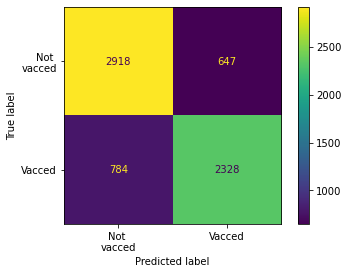

In [31]:
model_gbc_tuned = {'Gradient Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting'
print(model)
X_train_processed = model_gbc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned[model]['preprocessor'].transform(X_test)
model_gbc_tuned[model]['fit_regressor'] = model_gbc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

### Tuning Gradient Boost #2

In [65]:
# # Grid_search for Gradient Boosting #2
# pipeline_gbc = Pipeline([( "preprocessor" , preprocessor),
#                        ("gbc",GradientBoostingClassifier(n_estimators=500, learning_rate=0.1))])

# parameters_gbc = {}
# parameters_gbc['gbc__min_samples_leaf'] = [5, 10]#[1, 5, 10]
# parameters_gbc['gbc__max_depth'] = [3, 5, 10]#, 15, 20]

# gs_gbc=GridSearchCV(pipeline_gbc,parameters_gbc)

# gs_gbc.fit(X_train,y_train.seasonal_vaccine)

# gs_gbc.best_params_

{'gbc__max_depth': 3, 'gbc__min_samples_leaf': 5}

Gradient Boosting 2
{'Gradient Boosting 2': {'regressor': GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
               

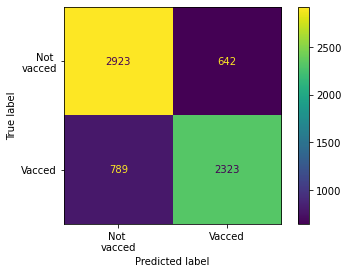

In [32]:
model_gbc_tuned_2 = {'Gradient Boosting 2':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5, n_estimators=500, learning_rate=0.01),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting 2'
print('Gradient Boosting 2')
X_train_processed = model_gbc_tuned_2[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned_2[model]['preprocessor'].transform(X_test)
model_gbc_tuned_2[model]['fit_regressor'] = model_gbc_tuned_2[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned_2)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned_2[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

Gradient Boosting 3
{'Gradient Boosting 3': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=6, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effect

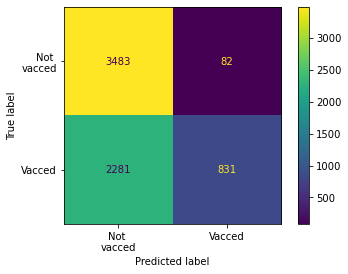

In [36]:
model_gbc_tuned_3 = {'Gradient Boosting 3':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=6, n_estimators=100, learning_rate=0.001),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting 3'
print(model)
X_train_processed = model_gbc_tuned_3[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned_3[model]['preprocessor'].transform(X_test)
model_gbc_tuned_3[model]['fit_regressor'] = model_gbc_tuned_3[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned_3)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned_3[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

Gradient Boosting 4
{'Gradient Boosting 4': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=5, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
              

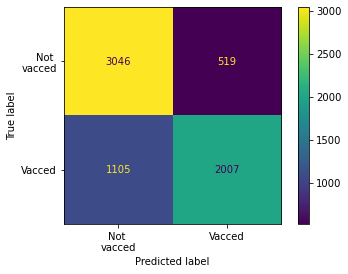

In [33]:
model_gbc_tuned_4 = {'Gradient Boosting 4':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5, n_estimators=500, learning_rate=0.001),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting 4'
print(model)
X_train_processed = model_gbc_tuned_4[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned_4[model]['preprocessor'].transform(X_test)
model_gbc_tuned_4[model]['fit_regressor'] = model_gbc_tuned_4[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned_4)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned_4[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

Gradient Boosting 5
{'Gradient Boosting 5': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=7, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
              

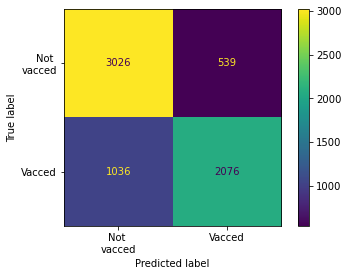

In [92]:
model_gbc_tuned_5 = {'Gradient Boosting 5':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=7, n_estimators=500, learning_rate=0.001),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting 5'
print(model)
X_train_processed = model_gbc_tuned_5[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned_5[model]['preprocessor'].transform(X_test)
model_gbc_tuned_5[model]['fit_regressor'] = model_gbc_tuned_5[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned_5)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned_5[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

## Tuning Hist Boost

In [ ]:
# # Grid_search for Hist Boost
# pipeline_hbc = Pipeline([( "preprocessor" , preprocessor),
#                        ("hbc",HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100,))])

# parameters_hbc = {}
# parameters_hbc['hbc__min_samples_leaf'] = [5, 10]
# parameters_hbc['hbc__max_depth'] = [5, 10, 15]

# gs_hbc=GridSearchCV(pipeline_hbc,parameters_hbc)

# gs_hbc.fit(X_train,y_train.seasonal_vaccine)

# gs_hbc.best_params_

Hist Boosting
{'Hist Boosting': {'regressor': HistGradientBoostingClassifier(max_depth=10, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                      

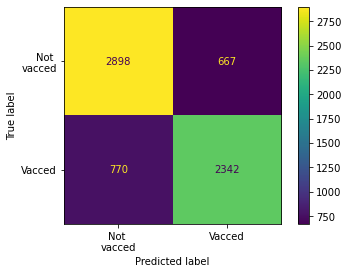

In [39]:
model_hbc_tuned = {'Hist Boosting':
              {'regressor': HistGradientBoostingClassifier(max_depth=10, min_samples_leaf=5),
               'preprocessor': preprocessor}}

model = 'Hist Boosting'
print(model)
X_train_processed = model_hbc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_hbc_tuned[model]['preprocessor'].transform(X_test)
model_hbc_tuned[model]['fit_regressor'] = model_hbc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_hbc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_hbc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_hbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_hbc, display_labels=['Not \nvacced', 'Vacced']).plot()

Hist Boosting 2
{'Hist Boosting 2': {'regressor': HistGradientBoostingClassifier(max_depth=9, min_samples_leaf=10), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                  

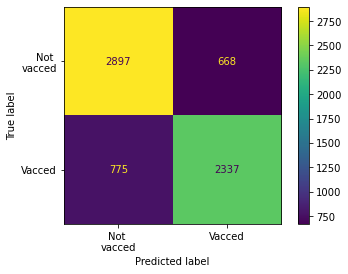

In [41]:
model_hbc_tuned_2 = {'Hist Boosting 2':
              {'regressor': HistGradientBoostingClassifier(max_depth=9, min_samples_leaf=10, learning_rate=0.1),
               'preprocessor': preprocessor}}

model = 'Hist Boosting 2'
print(model)
X_train_processed = model_hbc_tuned_2[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_hbc_tuned_2[model]['preprocessor'].transform(X_test)
model_hbc_tuned_2[model]['fit_regressor'] = model_hbc_tuned_2[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_hbc_tuned_2)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_hbc_tuned_2[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_hbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_hbc, display_labels=['Not \nvacced', 'Vacced']).plot()

In [42]:
precision_dict

{'Logistic': 0.7746526601152152,
 'Naive_Bayes': 0.6257470119521913,
 'Decision_Trees': 0.6526592252133946,
 'KNN': 0.7037037037037037,
 'Random_Forest': 0.7786467188031282,
 'G_Boost': 0.7829744279946165,
 'Hist_Boost': 0.7753551370994384,
 'Baseline': 0.6783461807988788}

In [43]:
accuracy_dict

{'Logistic': 0.7766961210124307,
 'Naive_Bayes': 0.6851879586640707,
 'Decision_Trees': 0.673206529878688,
 'KNN': 0.7184364235435076,
 'Random_Forest': 0.7793919424891418,
 'G_Boost': 0.785831960461285,
 'Hist_Boost': 0.7835854425640257,
 'Baseline': 0.6863861015426089}

In [44]:
precision_dict_tuned

{'Naive Bayes Tuned': 0.6908442330558858,
 'Decision Tree': 0.7406779661016949,
 'Random Forest': 0.7828153564899452,
 'Gradient Boosting': 0.7825210084033614,
 'Gradient Boosting 2': 0.7834738617200675,
 'Gradient Boosting 4': 0.7945368171021377,
 'Gradient Boosting 5': 0.7938814531548757,
 'Gradient Boosting 3': 0.9101861993428259,
 'Hist Boosting': 0.7783316716517116,
 'Hist Boosting 2': 0.7777038269550749}

In [45]:
accuracy_dict_tuned

{'Naive Bayes Tuned': 0.7262243522540063,
 'Decision Tree': 0.7465927811891568,
 'Random Forest': 0.7656132993859518,
 'Gradient Boosting': 0.7856821926014678,
 'Gradient Boosting 2': 0.7856821926014678,
 'Gradient Boosting 4': 0.7567769956567321,
 'Gradient Boosting 5': 0.764115620787779,
 'Gradient Boosting 3': 0.6460985472517597,
 'Hist Boosting': 0.784783585442564,
 'Hist Boosting 2': 0.7838849782836603}

In [55]:
accuracy_v_tuned = [v for v in accuracy_dict_tuned.values()]
accuracy_v_tuned

[0.7262243522540063,
 0.7465927811891568,
 0.7656132993859518,
 0.7856821926014678,
 0.7856821926014678,
 0.7567769956567321,
 0.764115620787779,
 0.6460985472517597,
 0.784783585442564,
 0.7838849782836603]

In [48]:
precision_v_tuned = [v for v in precision_dict_tuned.values()]
precision_v_tuned

[0.6908442330558858,
 0.7406779661016949,
 0.7828153564899452,
 0.7825210084033614,
 0.7834738617200675,
 0.7945368171021377,
 0.7938814531548757,
 0.9101861993428259,
 0.7783316716517116,
 0.7777038269550749]

In [50]:
auc_dict

{'Logistic': 0.7740200355498509,
 'Naive_Bayes': 0.6929602011126454,
 'Decision_Trees': 0.6710216435857037,
 'KNN': 0.7162361144661933,
 'Random_Forest': 0.7766262434335531,
 'G_Boost': 0.7834124882371817,
 'Hist_Boost': 0.7817170199418078,
 'Baseline': 0.6823022314201553}

In [51]:
auc_dict_tuned

{'Naive Bayes Tuned': 0.7275307636007023,
 'Decision Tree': 0.7275307636007023,
 'Random Forest': 0.7606810446464304,
 'Gradient Boosting': 0.7832926517088085,
 'Gradient Boosting 2': 0.7831905720785846,
 'Gradient Boosting 4': 0.7496704157457716,
 'Gradient Boosting 5': 0.6220147229022523,
 'Gradient Boosting 3': 0.6220147229022523,
 'Hist Boosting': 0.7827369599469275,
 'Hist Boosting 2': 0.781793365590196}

In [ ]:
precision_v = [v for v in precision_dict_tuned.values()]
precision_v

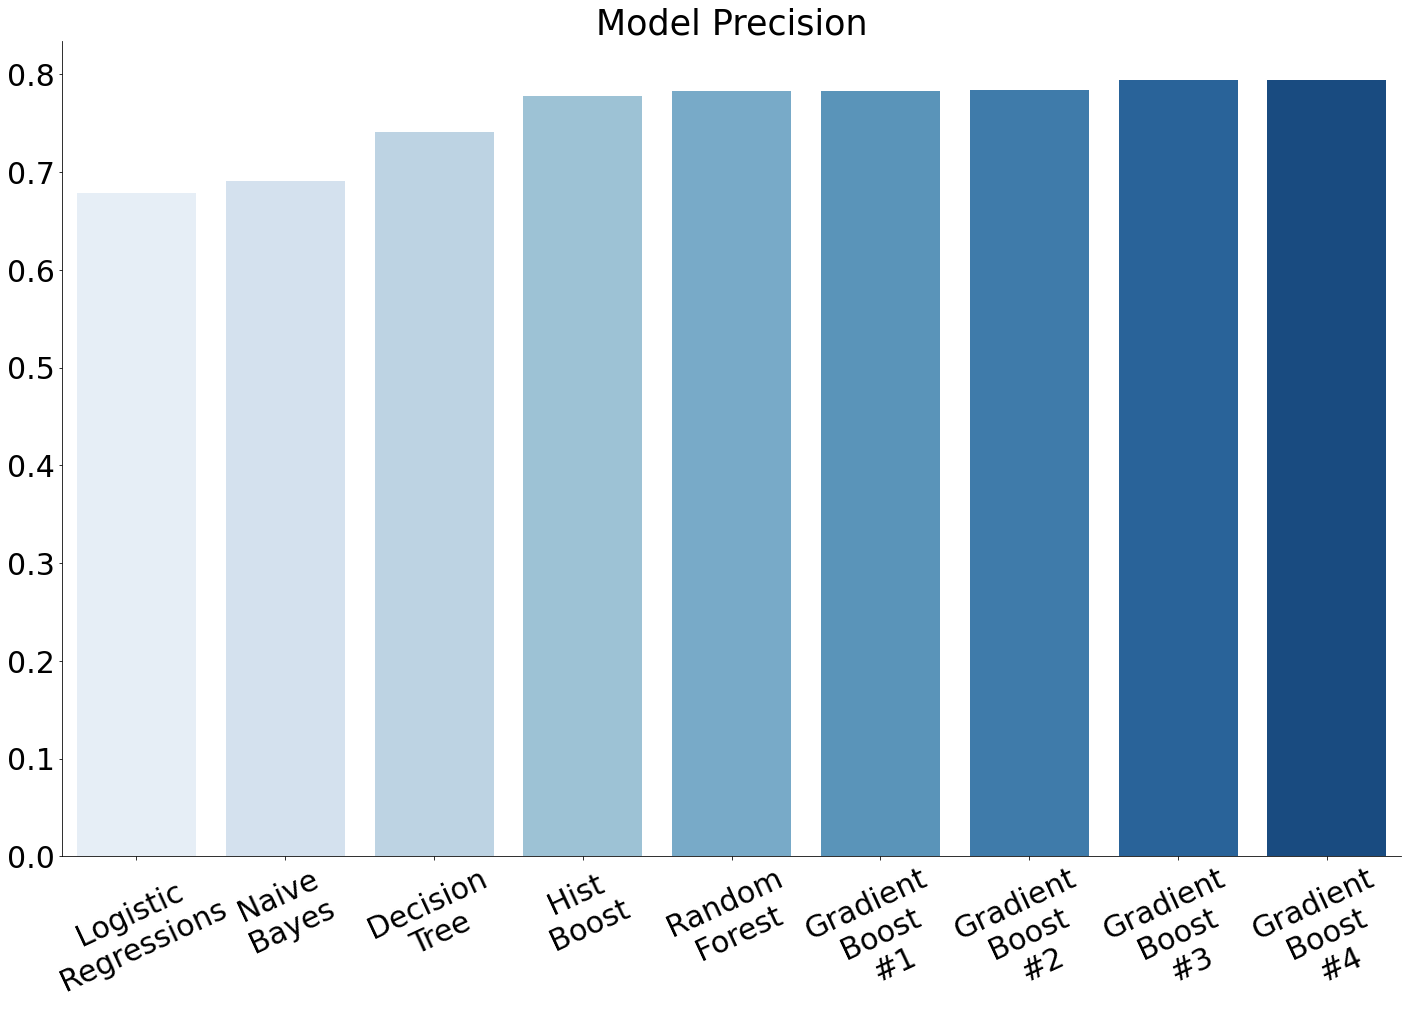

In [96]:
precision = [precision_dict['Baseline'], precision_v_tuned[0], precision_v_tuned[1], precision_v_tuned[9], precision_v_tuned[2], precision_v_tuned[3], precision_v_tuned[4], precision_v_tuned[5], precision_v_tuned[6]]#, precision_v_tuned[7]]
names = ['Logistic\nRegressions', 'Naive\nBayes', 'Decision\nTree', 'Hist\nBoost', 'Random\nForest', 'Gradient\nBoost\n#1', 'Gradient\nBoost\n#2', 'Gradient\nBoost\n#3', 'Gradient\nBoost\n#4']#, 'Gradient\nBoost\n#5']
accuracy = [accuracy_v_tuned[0], accuracy_v_tuned[1], accuracy_v_tuned[9], accuracy_v_tuned[2], accuracy_v_tuned[3], accuracy_v_tuned[4], accuracy_v_tuned[5], accuracy_v_tuned[6]]#, accuracy_v_tuned[7]]

fig, ax = plt.subplots(figsize=(24, 15))
x_label = names
ax = sns.barplot(x_label, precision, palette="Blues")
# sns.barplot(x_label, accuracy, palette="mako", ax=ax)
plt.xticks(rotation=25, size=30)
plt.yticks(size=30)
sns.despine()
ax.set_title('Model Precision', fontsize=35)
# plt.savefig('Skyler_graph', bbox_inches='tight');

In [72]:
pipeline_f_i = Pipeline([('preprocessor', preprocessor),
            ('gbc', GradientBoostingClassifier(min_samples_leaf=5, max_depth=7, n_estimators=500, learning_rate=0.001))])
pipeline_f_i.fit(X_test, y_test.seasonal_vaccine)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                         

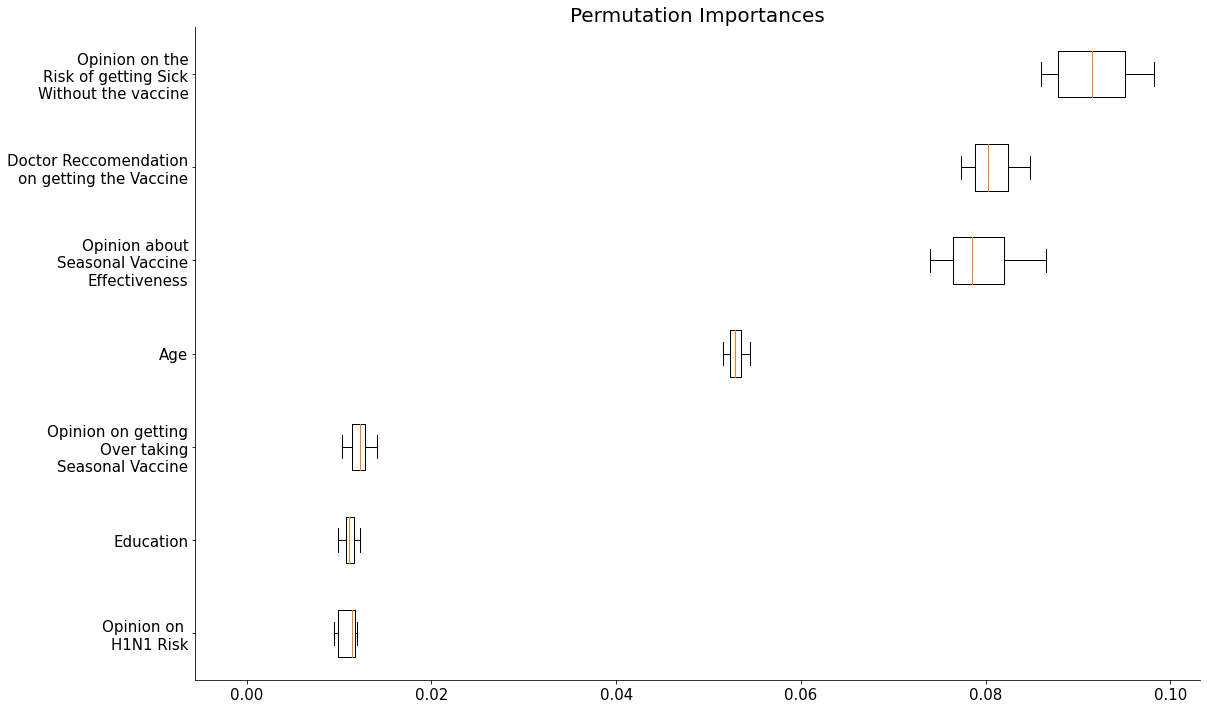

In [89]:
result = permutation_importance(
    pipeline_f_i, X_test, y_test.seasonal_vaccine, n_repeats=10, random_state=RANDOM_SEED, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(18, 12))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx], showfliers=False
)

ax.set_title("Permutation Importances", fontsize=30)#20
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine()
#ax.set_ylim(bottom=25.5, top=32.5)
#labels = [i for i in range(0,25)] + ['Opinion on \nH1N1 Risk', 'Education', 'Opinion on getting\nOver taking\nSeasonal Vaccine', 'Age', 'Opinion about\nSeasonal Vaccine\nEffectiveness', 'Doctor Reccomendation\non getting the Vaccine', 'Opinion on the\nRisk of getting Sick\nWithout the vaccine']
ax.set_yticklabels(labels)

#plt.savefig('Permutation_Importances2', bbox_inches='tight');